In [1]:
using CSV
using JLD
using Random
using PhyloPlots
using DataFrames
using SparseArrays
using Distributions
using Combinatorics
using PhyloNetworks
using PhyloCoalSimulations
using MLBase
using Hungarian
using LinearAlgebra
using ParallelKMeans
using MultivariateStats
using Distances
using Clustering
using CairoMakie

In [2]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;

function simulate_trees(tree, target, i, j, n_taxon)
    d = Uniform(0.5, 2)
    Random.seed!((123 + i) * j)
    n = length(tree.edge)

    x = rand(d, n)
    idx = 1
    for e in tree.edge
        e.length += x[idx]
        e.length = round(e.length, digits = 2)
        idx += 1
    end

    tree = simulatecoalescent(tree, 50, 1)
    tree = print_bipartition(tree, n_taxon)
    tree = sparse(tree)
    jldopen(target, "w") do file
        write(file, "tree", tree)
    end
end;

In [3]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_2)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

# Kmeans
function kmeans_label(tree, n; seed =:"k-means++")  
    result = kmeans(tree, n; k_init ="k-means++");
    return result.assignments
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [4]:
function hc_label(matrix; linkage=:ward, k=2 )
    H = hclust(matrix,linkage = linkage)
    return pred = cutree(H, k=k)
end

function hc_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            matrix = pairwise(Euclidean(), tree, dims=2)
            pred = hc_label(matrix)
            m,x = accuracy(2, gt, pred)
            result[i,j] = x
            result[j,i] = x
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

hc_matrix (generic function with 1 method)

In [5]:
Random.seed!(3);
base = "((((6:0.0,7:0.0):0.0,(4:0.0,2:0.0):0.0):0.0,(8:0.0,(5:0.0,3:0.0):0.0):0.0):0.0,1:0.0);"

base_tree = readTopology(base);
nni!(base_tree, base_tree.edge[3], true, true);
tree1 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[11], true, true);
tree2 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[12], true, true);
tree3 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[6], true, true);
tree4 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[3], true, true);
tree5 = writeTopology(base_tree)

"(((5:0.0,8:0.0):0.0,(3:0.0,((7:0.0,2:0.0):0.0,(6:0.0,4:0.0):0.0):0.0):0.0):0.0,1:0.0);"

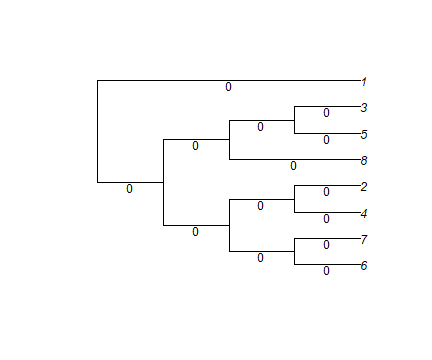

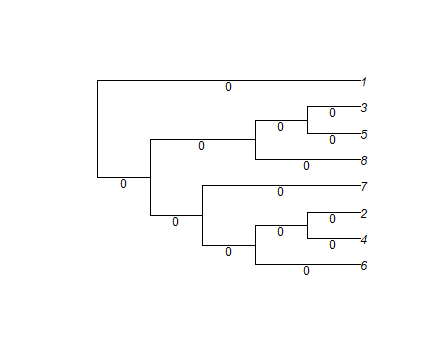

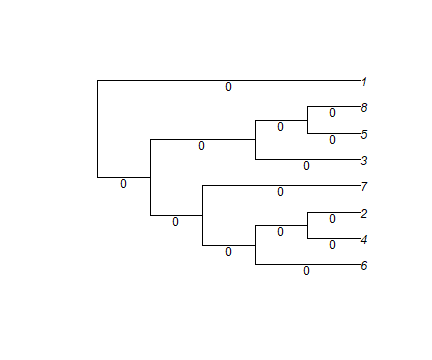

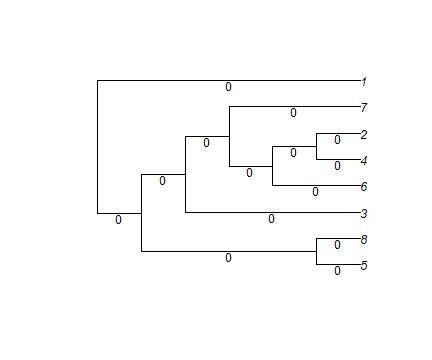

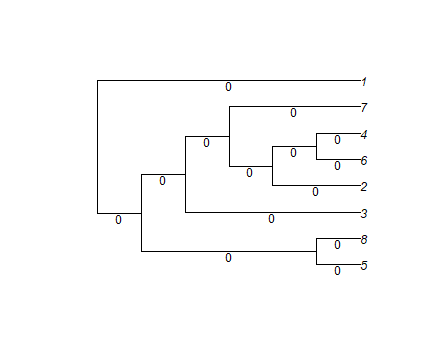

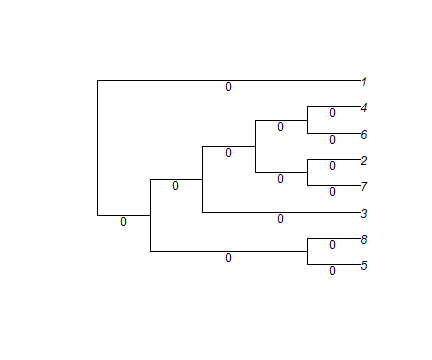

In [14]:
tree0 = readTopology(base);
PhyloPlots.plot(tree0, :R, showEdgeLength=true);
tree1 = readTopology(tree1);
PhyloPlots.plot(tree1, :R, showEdgeLength=true);
tree2 = readTopology(tree2);
PhyloPlots.plot(tree2, :R, showEdgeLength=true);
tree3 = readTopology(tree3);
PhyloPlots.plot(tree3, :R, showEdgeLength=true);
tree4 = readTopology(tree4);
PhyloPlots.plot(tree4, :R, showEdgeLength=true);
tree5 = readTopology(tree5);
PhyloPlots.plot(tree5, :R, showEdgeLength=true);

In [12]:
for i in 1:100
    simulate_trees(tree0, "data/nni/8_base_0_move_" * string(i) * ".jld", i, 1, 8)
    simulate_trees(tree1, "data/nni/8_base_1_move_" * string(i) * ".jld", i, 2, 8)
    simulate_trees(tree2, "data/nni/8_base_2_move_" * string(i) * ".jld", i, 3, 8)
    simulate_trees(tree3, "data/nni/8_base_3_move_" * string(i) * ".jld", i, 4, 8)
    simulate_trees(tree4, "data/nni/8_base_4_move_" * string(i) * ".jld", i, 5, 8)
    simulate_trees(tree5, "data/nni/8_base_5_move_" * string(i) * ".jld", i, 6, 8)
end

In [12]:
for k in 1:100
    trees = []
    for i in 1:6    
        path = "data/nni/8_base_" * string(i-1) *"_move_" * string(k) * ".jld"
        tree = jldopen(path, "r") do file
            read(file, "tree")
        end
        push!(trees, tree)
    end

    n = length(trees)
    result = zeros(n, n)

    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            for k in 1:100
                pred_kmeans = kmeans_label(tree, 2) 
                m,x = accuracy(2, gt, pred_kmeans)
                if x > result[i,j]
                    result[i,j] = x
                    result[j,i] = x
                end
            end
        end
    end
    header = Vector(1:n)
    header = string.(header)
    CSV.write("data/nni/result/kmeans_nni_8_reuslt_"* string(k) * ".csv", DataFrame(result, :auto), header = header);
end

In [11]:
for k in 1:100
    trees = []
    for i in 1:6    
        path = "data/nni/8_base_" * string(i-1) *"_move_" * string(k) * ".jld"
        tree = jldopen(path, "r") do file
            read(file, "tree")
        end
        push!(trees, tree)
    end

    n = length(trees)
    result = zeros(n, n)

    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            matrix = pairwise(Euclidean(), tree, dims=2)
            pred = hc_label(matrix)
            m,x = accuracy(2, gt, pred)
            result[i,j] = x
            result[j,i] = x
        end
    end
    header = Vector(1:n)
    header = string.(header)
    CSV.write("data/nni/result/hc_nni_8_reuslt_"* string(k) * ".csv", DataFrame(result, :auto), header = header);
end

In [12]:
Random.seed!(3);
base = "((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,14:0.0):0.0,(((11:0.0,(8:0.0,13:0.0):0.0):0.0,(12:0.0,(5:0.0,(3:0.0,15:0.0):0.0):0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,16:0.0):0.0);"

base_tree = readTopology(base);
nni!(base_tree, base_tree.edge[13], true, true)
tree1 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[19], true, true)
tree2 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[8], true, true)
tree3 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[20], true, true)
tree4 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[28], true, true)
tree5 = writeTopology(base_tree);

In [13]:
treestring = [base, tree1, tree2, tree3, tree4, tree5]
for s in treestring
    print("\\item " * s * "\n")
end

\item ((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,14:0.0):0.0,(((11:0.0,(8:0.0,13:0.0):0.0):0.0,(12:0.0,(5:0.0,(3:0.0,15:0.0):0.0):0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,16:0.0):0.0);
\item ((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,14:0.0):0.0,(((11:0.0,(12:0.0,(5:0.0,(3:0.0,15:0.0):0.0):0.0):0.0):0.0,(8:0.0,13:0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,16:0.0):0.0);
\item ((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,14:0.0):0.0,(((11:0.0,((3:0.0,15:0.0):0.0,(5:0.0,12:0.0):0.0):0.0):0.0,(8:0.0,13:0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,16:0.0):0.0);
\item ((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,(((11:0.0,((3:0.0,15:0.0):0.0,(5:0.0,12:0.0):0.0):0.0):0.0,(8:0.0,13:0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,14:0.0):0.0,16:0.0):0.0);
\item ((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,((((5:0.0,12:0.0):0.0,(11:0.0,(3:0.0,15:0.0):0.0):0.0):0.0,(8:0.0,13:0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,14:0.0):0.0,16:0.0):0.0);
\item ((6:0.0,(10:0.

In [9]:
tree0 = readTopology(base);
tree1 = readTopology(tree1);
tree2 = readTopology(tree2);
tree3 = readTopology(tree3);
tree4 = readTopology(tree4);
tree5 = readTopology(tree5);

In [10]:
for i in 1:100
    simulate_trees(tree0, "data/nni/16_base_0_move_" * string(i) * ".jld", i, 1, 16)
    simulate_trees(tree1, "data/nni/16_base_1_move_" * string(i) * ".jld", i, 2, 16)
    simulate_trees(tree2, "data/nni/16_base_2_move_" * string(i) * ".jld", i, 3, 16)
    simulate_trees(tree3, "data/nni/16_base_3_move_" * string(i) * ".jld", i, 4, 16)
    simulate_trees(tree4, "data/nni/16_base_4_move_" * string(i) * ".jld", i, 5, 16)
    simulate_trees(tree5, "data/nni/16_base_5_move_" * string(i) * ".jld", i, 6, 16)
end

In [13]:
for k in 1:100
    trees = []
    for i in 1:6    
        path = "data/nni/16_base_" * string(i-1) *"_move_" * string(k) * ".jld"
        tree = jldopen(path, "r") do file
            read(file, "tree")
        end
        push!(trees, tree)
    end

    n = length(trees)
    result = zeros(n, n)

    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            for k in 1:10
                pred_kmeans = kmeans_label(tree, 2) 
                m,x = accuracy(2, gt, pred_kmeans)
                if x > result[i,j]
                    result[i,j] = x
                    result[j,i] = x
                end
            end
        end
    end
    header = Vector(1:n)
    header = string.(header)
    CSV.write("data/nni/result/kmeans_nni_16_reuslt_"* string(k) * ".csv", DataFrame(result, :auto), header = header);
end

In [14]:
for k in 1:100
    trees = []
    for i in 1:6    
        path = "data/nni/16_base_" * string(i-1) *"_move_" * string(k) * ".jld"
        tree = jldopen(path, "r") do file
            read(file, "tree")
        end
        push!(trees, tree)
    end

    n = length(trees)
    result = zeros(n, n)

    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            matrix = pairwise(Euclidean(), tree, dims=2)
            pred = hc_label(matrix)
            m,x = accuracy(2, gt, pred)
            result[i,j] = x
            result[j,i] = x
        end
    end
    header = Vector(1:n)
    header = string.(header)
    CSV.write("data/nni/result/hc_nni_16_reuslt_"* string(k) * ".csv", DataFrame(result, :auto), header = header);
end

In [25]:
tree_1 = jldopen("data/nni/8_base_0_move_2.jld", "r") do file
    read(file, "tree")
end

tree_2 = jldopen("data/nni/8_base_1_move_2.jld", "r") do file
    read(file, "tree")
end

tree_3 = jldopen("data/nni/16_base_3_move_66.jld", "r") do file
    read(file, "tree")
end

tree_4 = jldopen("data/nni/16_base_4_move_66.jld", "r") do file
    read(file, "tree")
end

50×32767 SparseMatrixCSC{Float64, Int64} with 1450 stored entries:
⠛⠀⠃⠀⠀⠘⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

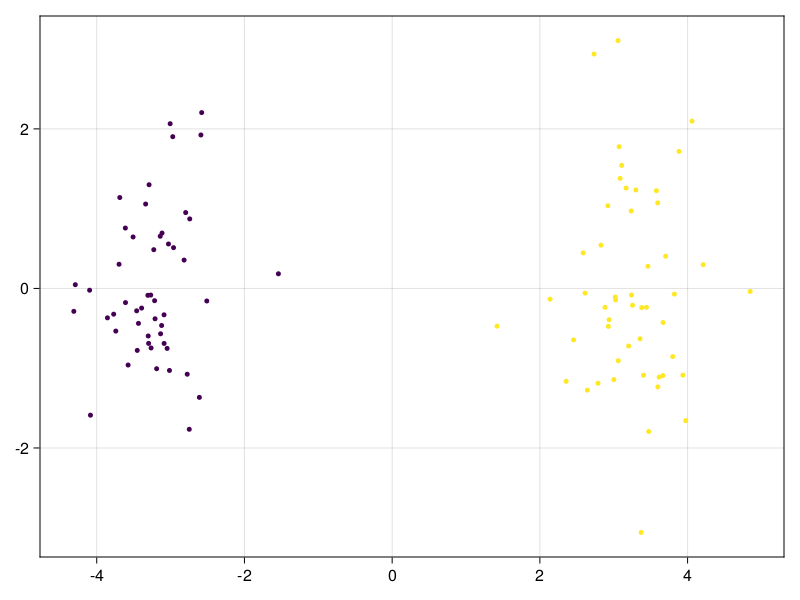

In [26]:
tree = vcat(tree_1 ,tree_2)
tree = standardize_tree(tree)
gt = ground_true(tree_1,tree_2)


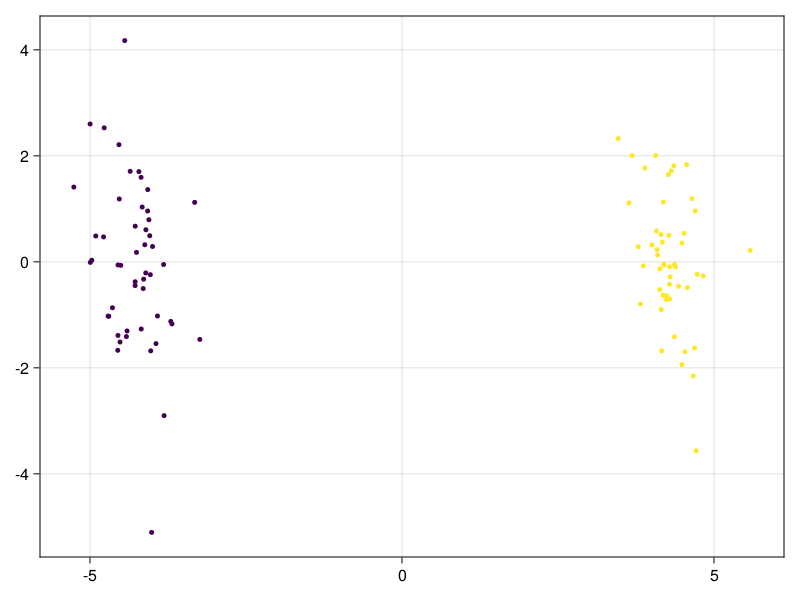

In [27]:
tree = vcat(tree_3 ,tree_4)
tree = standardize_tree(tree)
gt = ground_true(tree_3,tree_4)
plot_clusters(tree, gt)

In [62]:
"""
Random.seed!(3);
base = "((5:0.0,(((31:0.0,26:0.0):0.0,9:00):0.0,(29:0.0,20:0.0):0.0):0.0):0.0,(((27:0.0,10:0.0):0.0,((((12:0.0,(30:0.0,17:0.0):0.0):0.0,((18:0.0,2:0.0):0.0,6:0.0):0.0):0.0,(16:0.0,((8:0.0,22:0.0):0.0,(23:0.0,(((13:0.0,3:0.0):0.0,14:0.0):0.0,((25:0.0,15:0.0):0.0,11:0.0):0.0):0.0):0.0):0.0):0.0):0.0,(((19:0.0,32:0.0):0.0,(4:0.0,(1:0.0,28:0.0):0.0):0.0):0.0,(24:0.0,21:0.0):0.0):0.0):0.0):0.0,7:0.0):0.0);"

base_tree = readTopology(base);
nni!(base_tree, base_tree.edge[43], true, true)
tree1 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[19], true, true)
tree2 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[22], true, true)
tree3 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[6], true, true)
tree4 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[33], true, true)
tree5 = writeTopology(base_tree);

tree0 = readTopology(base);
tree1 = readTopology(tree1);
tree2 = readTopology(tree2);
tree3 = readTopology(tree3);
tree4 = readTopology(tree4);
tree5 = readTopology(tree5);

for i in 1:100
    simulate_trees(tree0, "data/nni/32_base_0_move_" * string(i) * ".jld", i, 1, 32)
    simulate_trees(tree1, "data/nni/32_base_1_move_" * string(i) * ".jld", i, 2, 32)
    simulate_trees(tree2, "data/nni/32_base_2_move_" * string(i) * ".jld", i, 3, 32)
    simulate_trees(tree3, "data/nni/32_base_3_move_" * string(i) * ".jld", i, 4, 32)
    simulate_trees(tree4, "data/nni/32_base_4_move_" * string(i) * ".jld", i, 5, 32)
    simulate_trees(tree5, "data/nni/32_base_5_move_" * string(i) * ".jld", i, 6, 32)
end
"""